In [9]:
import matplotlib
matplotlib.use('TkAgg')  # Enable GUI backend
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [10]:

# Grid parameters
nx = 200    # 1000 km / 5 km
ny = 100    # 500 km / 5 km
dx = 5.e3   # 5 km
dy = 5.e3

# Create coordinate arrays
X, Y = np.meshgrid(np.arange(nx)*dx, np.arange(ny)*dy)

# Center of island
cx = 500.e3  # 500 km from west → center
cy = 250.e3  # 250 km from south → center
radius = 50.e3      # 50 km radius
slope_width = 30.e3  # 30 km slope

# Distance from center
r = np.sqrt((X - cx)**2 + (Y - cy)**2)

# Initialize depth: 1000 m everywhere
depth = np.ones((ny, nx)) * 1000.0

# Smooth ramp: depth decreases as r increases
mask = r < radius + slope_width
taper = np.zeros_like(r)
taper[mask] = np.minimum(1.0, (radius + slope_width - r[mask]) / slope_width)
depth[mask] = 1000.0 * (1.0 - taper[mask])

# Inside the island, set depth to 0 (dry land)
depth[r < radius] = 0.0

# Save bathymetry
#depth.astype('>f4').tofile('../input/bathy.bin')


In [8]:

# --- Gaussian Eddy ---
ex = 800.e3   # 800 km from west (east of island)
ey = 250.e3   # centered in y
eddy_radius = 100.e3
eta0_max = 0.5  # 50 cm SSH anomaly

# Gaussian SSH
r2 = (X - ex)**2 + (Y - ey)**2
eta0 = eta0_max * np.exp(-r2 / (2 * eddy_radius**2))

# Save initial SSH
#eta0.astype('>f4').tofile('../input/initial_eta.bin')

# --- Plot 2D ---
plt.figure(figsize=(12, 6))


# Bathymetry
plt.subplot(1, 2, 1)
plt.imshow(depth, origin='lower', extent=[0, nx*dx/1000, 0, ny*dy/1000], cmap='Blues_r')
plt.colorbar(label='Depth (m)')
plt.contour(depth, levels=[0], colors='k', linewidths=2)
plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Bathymetry: Cylindrical Island')


# Initial SSH
plt.subplot(1, 2, 2)
plt.imshow(eta0, origin='lower', extent=[0, nx*dx/1000, 0, ny*dy/1000], cmap='RdYlBu_r')
plt.colorbar(label='SSH (m)')
plt.contour(eta0, levels=np.linspace(0.1, 0.5, 5), colors='k', linewidths=0.5)
plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Initial SSH: Gaussian Eddy')

plt.tight_layout()
#plt.savefig('../analysis/island_and_eddy.png', dpi=150, bbox_inches='tight')
plt.show()


KeyboardInterrupt: 

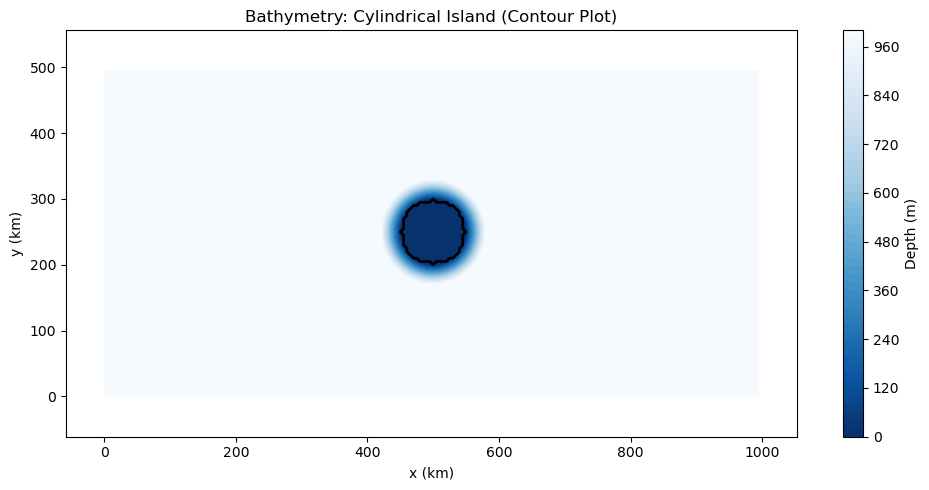

In [12]:
plt.figure(figsize=(10, 5))
# Filled contours
contourf = plt.contourf(X/1000, Y/1000, depth, levels=50, cmap='Blues_r')
plt.colorbar(contourf, label='Depth (m)')

# Add black contour lines for clarity
plt.contour(X/1000, Y/1000, depth, levels=[0], colors='k', linewidths=2)

plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Bathymetry: Cylindrical Island (Contour Plot)')
plt.axis('equal')
plt.tight_layout()
#plt.savefig('../analysis/bathy_contourf.png', dpi=150)
plt.show()

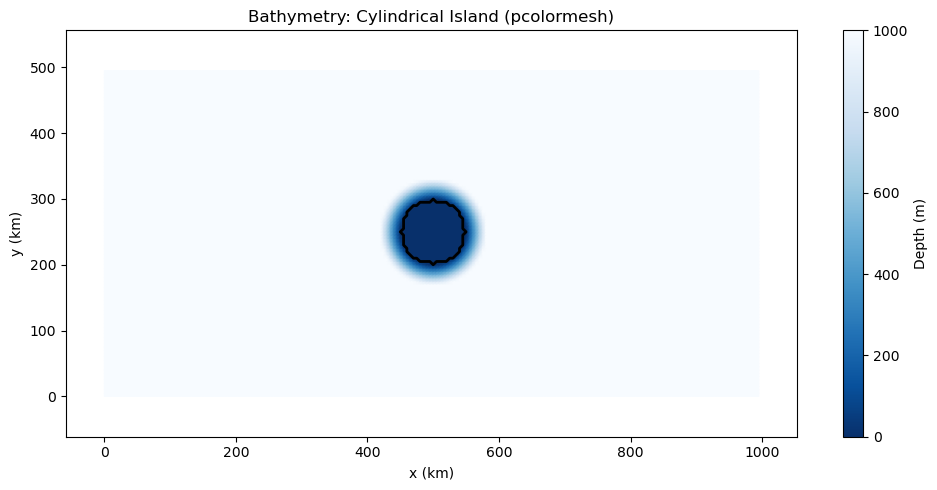

In [13]:
plt.figure(figsize=(10, 5))
# Use pcolormesh for cell-centered data
mesh = plt.pcolormesh(X/1000, Y/1000, depth, shading='gouraud', cmap='Blues_r')
plt.colorbar(mesh, label='Depth (m)')

# Overlay land boundary
plt.contour(X/1000, Y/1000, depth, levels=[0], colors='k', linewidths=2)

plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Bathymetry: Cylindrical Island (pcolormesh)')
plt.axis('equal')
plt.tight_layout()
plt.savefig('../analysis/bathy_pcolormesh.png', dpi=150)
plt.show()

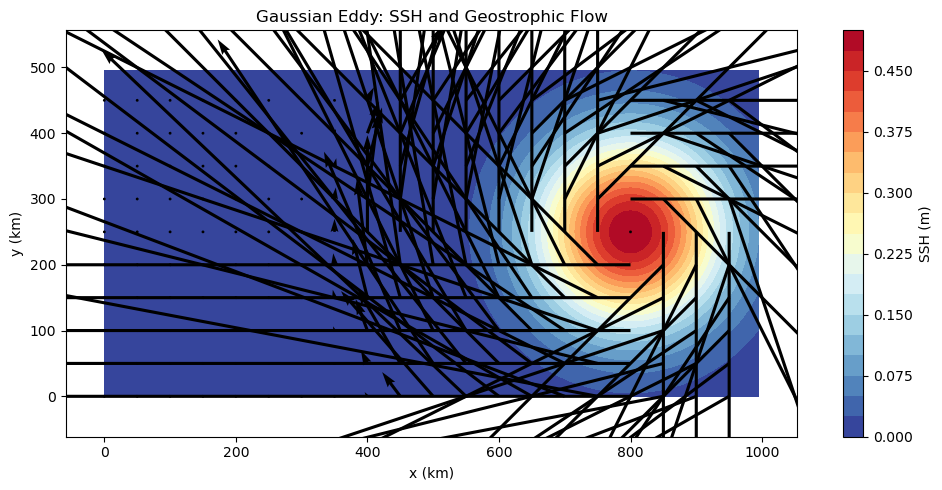

In [14]:
# Compute geostrophic velocity
f0 = 5.0e-5  # f at Hawaii
g = 9.8
deta_dx = np.gradient(eta0, axis=1) / dx
deta_dy = np.gradient(eta0, axis=0) / dy
v =  (g / f0) * deta_dx
u = -(g / f0) * deta_dy

# Plot
plt.figure(figsize=(10, 5))
contourf = plt.contourf(X/1000, Y/1000, eta0, levels=20, cmap='RdYlBu_r')
plt.colorbar(contourf, label='SSH (m)')
plt.quiver(X[::10,::10]/1000, Y[::10,::10]/1000, u[::10,::10], v[::10,::10], color='k', scale=1e-2)
plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Gaussian Eddy: SSH and Geostrophic Flow')
plt.axis('equal')
plt.tight_layout()
#plt.savefig('../analysis/eddy_with_flow.png', dpi=150)
plt.show()

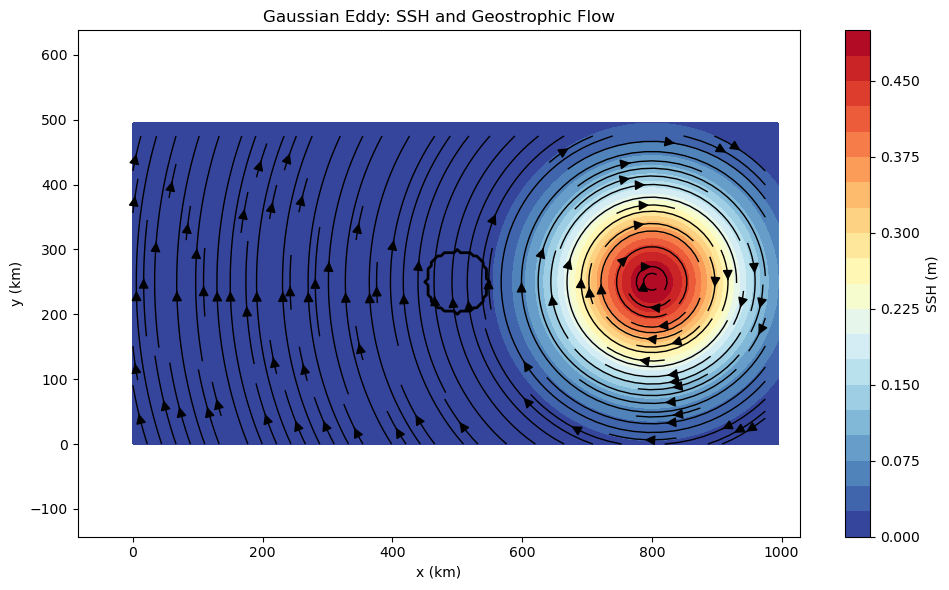

In [15]:
# Eddy
ex, ey = 800.e3, 250.e3
eddy_radius = 100.e3
eta0_max = 0.5
r2 = (X - ex)**2 + (Y - ey)**2
eta0 = eta0_max * np.exp(-r2 / (2 * eddy_radius**2))

# Geostrophic velocity
f0 = 5.0e-5  # f at Hawaii
g = 9.8
deta_dx = np.gradient(eta0, axis=1) / dx
deta_dy = np.gradient(eta0, axis=0) / dy
v =  (g / f0) * deta_dx
u = -(g / f0) * deta_dy

# Streamlines
plt.figure(figsize=(10, 6))
contourf = plt.contourf(X/1000, Y/1000, eta0, levels=20, cmap='RdYlBu_r')
plt.colorbar(contourf, label='SSH (m)')

# Streamlines (better than quiver)
stream = plt.streamplot(X[::5,::5]/1000, Y[::5,::5]/1000, u[::5,::5], v[::5,::5], 
                        density=1.5, linewidth=1, color='black', arrowsize=1.5)

# Overlay land boundary
plt.contour(X/1000, Y/1000, depth, levels=[0], colors='k', linewidths=2)

plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Gaussian Eddy: SSH and Geostrophic Flow')
plt.axis('equal')
plt.tight_layout()
#plt.savefig('../analysis/eddy_streamlines.png', dpi=150)
plt.show()

## New

In [3]:
import matplotlib
matplotlib.use('TkAgg')  # Enable GUI backend
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Grid parameters
nx = 200    # 1000 km / 5 km
ny = 100    # 500 km / 5 km
dx = 5.e3   # 5 km
dy = 5.e3

# Create coordinate arrays
X, Y = np.meshgrid(np.arange(nx)*dx, np.arange(ny)*dy)

# Center of island (closer to west)
cx = 300.e3  # 300 km from west
cy = 250.e3  # centered in y
radius = 50.e3      # 50 km radius
slope_width = 30.e3  # 30 km slope

# Distance from center
r = np.sqrt((X - cx)**2 + (Y - cy)**2)

# Initialize depth: 1000 m everywhere
depth = np.ones((ny, nx)) * 1000.0

# Smooth ramp: depth decreases as r increases
mask = r < radius + slope_width
taper = np.zeros_like(r)
taper[mask] = np.minimum(1.0, (radius + slope_width - r[mask]) / slope_width)
depth[mask] = 1000.0 * (1.0 - taper[mask])

# Inside the island, set depth to 0 (dry land)
depth[r < radius] = 0.0


# --- Gaussian Eddy ---
ex = 800.e3   # 800 km from west (east of island)
ey = 250.e3   # centered in y
eddy_radius = 100.e3
eta0_max = 0.5  # 50 cm SSH anomaly

# Gaussian SSH
r2 = (X - ex)**2 + (Y - ey)**2
eta0 = eta0_max * np.exp(-r2 / (2 * eddy_radius**2))



In [4]:
# --- Plot 2D ---
plt.figure(figsize=(12, 6))

# Bathymetry
plt.subplot(1, 2, 1)
plt.imshow(depth, origin='lower', extent=[0, nx*dx/1000, 0, ny*dy/1000], cmap='Blues_r')
plt.colorbar(label='Depth (m)')
plt.contour(depth, levels=[0], colors='k', linewidths=2)
plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Bathymetry: Cylindrical Island')

# Initial SSH
plt.subplot(1, 2, 2)
plt.imshow(eta0, origin='lower', extent=[0, nx*dx/1000, 0, ny*dy/1000], cmap='RdYlBu_r')
plt.colorbar(label='SSH (m)')
plt.contour(eta0, levels=np.linspace(0.1, 0.5, 5), colors='k', linewidths=0.5)
plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Initial SSH: Gaussian Eddy')

plt.tight_layout()
plt.show()

: 

In [1]:
import matplotlib
matplotlib.use('TkAgg')  # Enable GUI backend
import numpy as np
import matplotlib.pyplot as plt

# Grid parameters
nx = 200; ny = 100; dx = 5.e3; dy = 5.e3
X, Y = np.meshgrid(np.arange(nx)*dx, np.arange(ny)*dy)

# Island
cx = 300.e3; cy = 250.e3; radius = 50.e3; slope_width = 30.e3
r = np.sqrt((X - cx)**2 + (Y - cy)**2)
depth = np.ones((ny, nx)) * 1000.0
mask = r < radius + slope_width
taper = np.minimum(1.0, (radius + slope_width - r[mask]) / slope_width)
depth[mask] = 1000.0 * (1.0 - taper)
depth[r < radius] = 0.0  # Dry land

# Eddy
ex = 800.e3; ey = 250.e3; eddy_radius = 100.e3; eta0_max = 0.5
r2 = (X - ex)**2 + (Y - ey)**2
eta0 = eta0_max * np.exp(-r2 / (2 * eddy_radius**2))

# --- Combined Plot ---
plt.figure(figsize=(12, 6))

# Plot bathymetry
cf = plt.contourf(X/1000, Y/1000, depth, levels=50, cmap='Blues_r')
plt.colorbar(cf, label='Depth (m)')
plt.contour(X/1000, Y/1000, depth, levels=[0], colors='k', linewidths=2)  # Land boundary
plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Bathymetry: Cylindrical Island')

# Overlay eddy
plt.contourf(X/1000, Y/1000, eta0, levels=20, cmap='RdYlBu_r', alpha=0.7)
plt.contour(X/1000, Y/1000, eta0, levels=np.linspace(0.1, 0.5, 5), colors='k', linewidths=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()

: 

In [ ]:
# --- Plot 3D: Island and Eddy ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot island (bathymetry)
surf_island = ax.plot_surface(X/1000, Y/1000, depth, cmap='Blues_r', edgecolor='none', alpha=0.7)
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('Depth (m)')
ax.set_title('3D View: Island and Eddy')

# Overlay eddy (SSH)
surf_eddy = ax.plot_surface(X/1000, Y/1000, eta0, cmap='RdYlBu_r', edgecolor='none', alpha=0.9)

# Add land boundary
ax.contour(X/1000, Y/1000, depth, levels=[0], colors='k', linewidths=2)

ax.view_init(elev=20, azim=45)
plt.savefig('../analysis/island_eddy_3d.png', dpi=150, bbox_inches='tight')
plt.show()

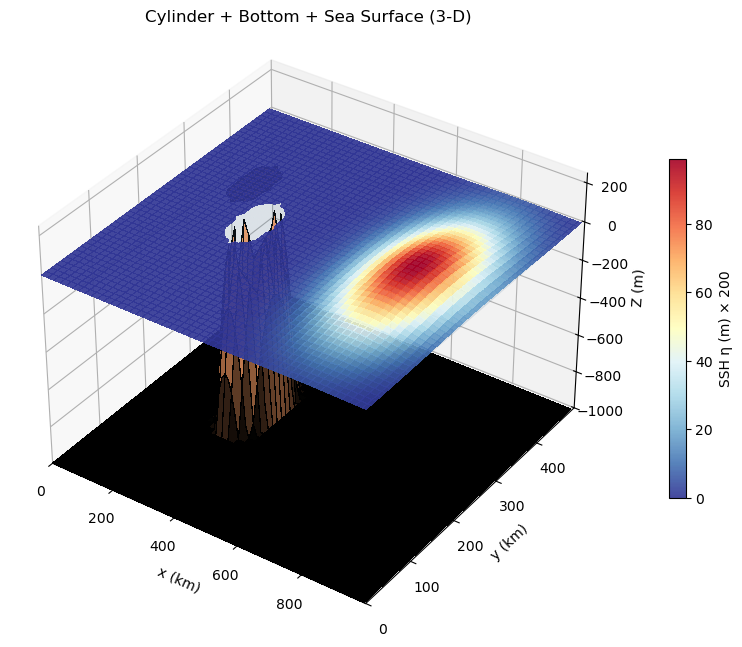

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- paths & grid (match your generator) ---
BASE = Path.cwd().parents[0]               # .../v0
nx, ny = 200, 100
dx, dy = 5e3, 5e3                          # m
x = (np.arange(nx))*dx/1e3                 # km
y = (np.arange(ny))*dy/1e3                 # km
X, Y = np.meshgrid(x, y, indexing='xy')

# --- read model inputs ---
depth = np.fromfile(BASE/'input'/'bathy.bin', dtype='>f4').reshape(ny, nx)   # m, +down
eta   = np.fromfile(BASE/'input'/'initial_eta.bin', dtype='>f4').reshape(ny, nx)  # m

# --- masks & heights for plotting ---
land = depth == 0.0

Z_bottom = -depth.astype(float)            # m (0 at sea surface, negative downward)
Z_bottom[land] = np.nan                    # don’t draw bottom under island

H_land = 200.0                             # m above sea level (plot only)
Z_land  = np.where(land, H_land, np.nan)   # island cap for visualization

z_exag  = 200.0                            # vertical exaggeration for SSH (m_plot per m_eta)
Z_surf  = np.where(~land, z_exag*eta, np.nan)

# --- plot ---
step = 2   # downsample to show grid cleanly and keep it fast
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111, projection='3d')

# bottom with grid lines
ax.plot_surface(X[::step,::step], Y[::step,::step], Z_bottom[::step,::step],
                cmap='copper', edgecolor='k', linewidth=0.15, antialiased=False)

# island above sea level (vis only)
ax.plot_surface(X[::step,::step], Y[::step,::step], Z_land[::step,::step],
                facecolor='peru', edgecolor='k', linewidth=0.15, antialiased=False)

# a translucent sea-level plane for reference
Z0 = np.zeros_like(X[::step,::step])
ax.plot_surface(X[::step,::step], Y[::step,::step], Z0,
                color='steelblue', alpha=0.15, edgecolor='none')

# sea surface = exaggerated eta(x,y)
surf = ax.plot_surface(X[::step,::step], Y[::step,::step], Z_surf[::step,::step],
                       cmap='RdYlBu_r', edgecolor='none', alpha=0.9, antialiased=False)
cb = fig.colorbar(surf, shrink=0.55, pad=0.08); cb.set_label(f'SSH η (m) × {z_exag:g}')

ax.view_init(35, -55)
ax.set_xlim(x.min(), x.max()); ax.set_ylim(y.min(), y.max())
ax.set_zlim(-depth.max(), H_land+50)
ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)'); ax.set_zlabel('Z (m)')
ax.set_title('Cylinder + Bottom + Sea Surface (3-D)')
plt.show()

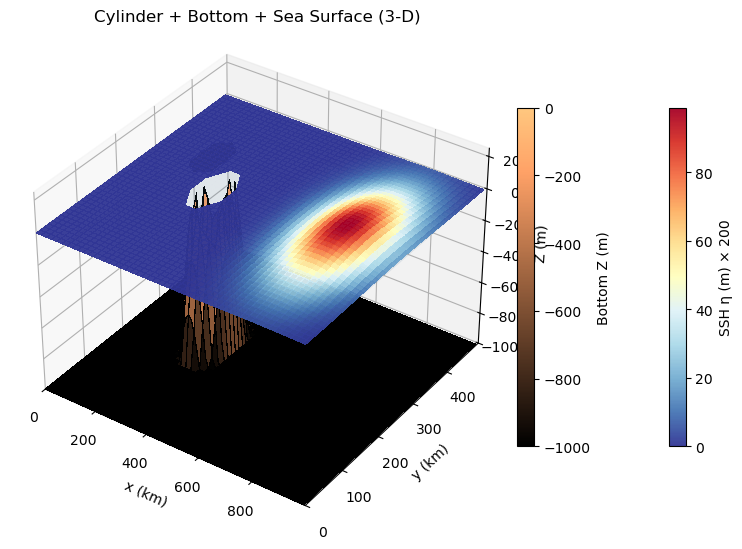

In [2]:
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D  # noqa

# ---- load from what you've already written ----
BASE = Path.cwd().parents[0]        # .../v0
ny, nx = 100, 200
dx, dy = 5e3, 5e3
x = (np.arange(nx))*dx/1e3
y = (np.arange(ny))*dy/1e3
X, Y = np.meshgrid(x, y, indexing='xy')

depth = np.fromfile(BASE/'input'/'bathy.bin', dtype='>f4').reshape(ny, nx)    # m (+down)
eta   = np.fromfile(BASE/'input'/'initial_eta.bin', dtype='>f4').reshape(ny, nx)  # m

land = depth == 0.0

# one-cell rim around land to avoid triangulation artifacts
rim = (land |
       np.roll(land, 1, 0) | np.roll(land, -1, 0) |
       np.roll(land, 1, 1) | np.roll(land, -1, 1))

# Heights to plot
Z_bottom = -depth.astype(float); Z_bottom[land] = np.nan
H_land   = 200.0                               # purely for visualization
Z_land   = np.where(land, H_land, np.nan)

z_exag   = 200.0                               # exaggerate SSH so you can see it
Z_surf   = np.where(~rim, z_exag*eta, np.nan)  # mask island + rim on sea surface

# ---- plot ----
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111, projection='3d')
step = 2  # display stride

# bottom (with grid)
bot_surf = ax.plot_surface(X[::step,::step], Y[::step,::step], Z_bottom[::step,::step],
                           cmap='copper', edgecolor='k', linewidth=0.15, antialiased=False)

# island cap
ax.plot_surface(X[::step,::step], Y[::step,::step], Z_land[::step,::step],
                facecolor='peru', edgecolor='k', linewidth=0.15, antialiased=False)

# sea-surface plane for reference
Z0 = np.zeros_like(X[::step,::step])
ax.plot_surface(X[::step,::step], Y[::step,::step], Z0,
                color='steelblue', alpha=0.12, edgecolor='none')

# sea surface = η(x,y) × exaggeration (no edges -> no “spikes”)
ssh_surf = ax.plot_surface(X[::step,::step], Y[::step,::step], Z_surf[::step,::step],
                           cmap='RdYlBu_r', edgecolor='none', alpha=0.95, antialiased=False)

# two colorbars
cb1 = fig.colorbar(ssh_surf, ax=ax, shrink=0.55, pad=0.08)
cb1.set_label(f'SSH η (m) × {z_exag:g}')
import matplotlib as mpl
mappable_bottom = mpl.cm.ScalarMappable(
    cmap='copper', norm=mpl.colors.Normalize(vmin=Z_bottom[~np.isnan(Z_bottom)].min(), vmax=0.0))
mappable_bottom.set_array([])
cb2 = fig.colorbar(mappable_bottom, ax=ax, shrink=0.55, pad=0.02)
cb2.set_label('Bottom Z (m)')

ax.view_init(35, -55)
ax.set_xlim(x.min(), x.max()); ax.set_ylim(y.min(), y.max())
ax.set_zlim(-depth.max(), H_land+50)
ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)'); ax.set_zlabel('Z (m)')
ax.set_title('Cylinder + Bottom + Sea Surface (3-D)')
plt.show()